# pineapple two-step model comparisons

In [1]:
import numpy as np
import pandas as pd
from typing import List
import seaborn as sns
from matplotlib import pyplot as plt
import os

#from featureio import FeatureIO 
#from calzone import Calzone

from pineapple.contrib.components.data_factories.matrix_factory import MatrixFactory as mf
#from pineapple.contrib.components.transformers.methyl.poisson_outlier import ChooseSettingsAndRegionsForPoissonV2
#from pineapple.contrib.specs.transformer_specs import ChooseSettingsAndRegionsForPoissonSpecV2

#from pineapple.contrib.results.results_loader import load_results
from pineapple.contrib.loaders.experiment_table_loader import ExperimentTableLoader, ExperimentLoader
import pineappleflow.core.experiment_context as experiment_context
import datetime
experiment_context.reset_context(0, "x", "x", datetime.datetime(2021, 8, 19,0,0))

from collections import defaultdict, Counter
print("a")

STATISTICAL TESTS: The most common metric functions have been moved to Pineappleflow. Please import by 'from pineappleflow.core.statistics_utils'. Currently includes: SensAndSpecMetrics, get_sens_and_spec, specificity_threshold_interpolated, specificity_thresholds


a


In [2]:
## see calibration of multinomial class probabilities: https://scikit-learn.org/stable/modules/calibration.html

In [135]:
HEALTHY_TYPES = ["Colorectal Normal / Healthy", "Pancreatic Normal / Healthy", "Normal / Healthy NOS", "Colorectal Benign"]
CANCER_TYPES = ["Colorectal Cancer", "Colorectal Pre-Cancer", "Uterine Cancer", "Breast Cancer", "Esophageal Cancer",
                "Ovarian Cancer", "Pancreatic Cancer", "Lung Cancer", "Liver Cancer", "Prostate Cancer"]
COLORS = ["orange", "orange", "blue", "green", "grey", "pink", "lightblue", "purple", "lightgreen","yellow"]

def generate_exp_table(bucket, path, chains=1, spec=90):
    loader = ExperimentLoader(bucket,path)
    
    dfs = []
    for fold_name in loader.fold_names():
        fold_loader = loader.fold(fold_name)
        test_sids = fold_loader.post_transformer_fold_holder.test.sample_ids
        test_calls = fold_loader.model_fold_result.test.predictions
        chain_scores = fold_loader.post_transformer_fold_holder['mint-chmcfc-VP2-intersect-CpGV2-dsc_v1/v1'].test.x
        #print(chain_scores.shape)
        metas = fold_loader.post_transformer_fold_holder['mint-chmcfc-VP2-intersect-CpGV2-dsc_v1/v1'].test.sample_metadata
        stages = [m.raw_sample_metadata['lims_top_diagnosis']['stage'] for m in metas]
        df = pd.DataFrame.from_dict({"sample_id": test_sids, 
                                           "fold": [fold_name]*len(test_sids),
                                           "fold_call": test_calls,
                                           "stage": stages,
                                           "chain0_score": chain_scores[:,0]})
        if chains == 2:
            df["chain1_score"] = chain_scores[:,1]
        
        dfs.append(df)
                      
    df_calls = pd.concat(dfs, axis=0)
                   
    table_loader = ExperimentTableLoader.from_experiment_loader(loader)
    df_samples = table_loader.sample_score_per_fold_table()
                   
    assert len(df_samples) == len(df_calls), f"Number total fold test samples {len(df_calls)} doesn't match number output samples {len(df_samples)}"
    
    df_samples_wcalls = pd.merge(df_samples, df_calls, on=["sample_id", "fold"], how="outer")
    
    assert len(df_samples_wcalls) == len(df_samples), f"Merged table {len(df_samples_wcalls)}. Orig: {len(df_samples)}"
    
    #	sample_id	fold	y_true	y_score	status	stage	subtype	inference chain0_score_mean chain1_score_mean
    return df_samples_wcalls


def plot_multicancer_sensitivities(df_samples, method='fold_score_avg', spec=90, nested=False, chains=2):
    '''
    Take the table of fold score averages, threshold them on the healthy scores, call.
    '''

    if method is "fold_score_avg":
        df_samples['score_mean'] = df_samples.groupby(['sample_id'])['y_score'].transform(lambda x: np.mean(x))
        df_samples['chain0_score_mean'] = df_samples.groupby(['sample_id'])['chain0_score'].transform(lambda x: np.mean(x))
        if chains == 2:
            df_samples['chain1_score_mean'] = df_samples.groupby(['sample_id'])['chain1_score'].transform(lambda x: np.mean(x))
        df_samples_avg = df_samples.drop_duplicates(subset=["sample_id"])
    
        healthies = [l in HEALTHY_TYPES for l in df_samples_avg["status"]]
        df_healthy = df_samples_avg[healthies]
        #final calls
        thresh = np.percentile(df_healthy["score_mean"].values, spec)
        df_samples_avg["call90"] = [1 if score>=thresh else 0 for score in df_samples_avg['score_mean']]
        #chain0 calls
        thresh = np.percentile(df_healthy["chain0_score_mean"].values, spec)
        df_samples_avg["chain0_call90"] = [1 if score>=thresh else 0 for score in df_samples_avg['chain0_score_mean']]
        #chain1 calls
        if chains == 2:
            thresh = np.percentile(df_healthy["chain1_score_mean"].values, spec)
            df_samples_avg["chain1_call90"] = [1 if score>=thresh else 0 for score in df_samples_avg['chain1_score_mean']]

        print(df_samples_avg.head())
        if nested is True:
            pass
#             # use only healthy samples called false positive by first model to calc spec. threshold 
#             call_0_thresh = np.percentile(df_sample_avg[healthies]["chain0_score_mean"].values, spec)
#             call_0s = [1 if score >= call_0_thresh else 0 for score in df_sample_avg["chain0_score_mean"]]
#             healthies = [call_0==1 and healthy is True for call_0,healthy in zip(call_0s,healthies)]
#             df_healthy = df_sample_avg[healthies]
#             thresh = np.percentile(df_healthy["score_mean"].values, spec)
#             df_sample_avg["call90"] = [1 if score>=thresh else 0 for score in df_sample_avg['score_mean']]
        
        call_col = "call90"
    
    elif method is "maj_vote":
        def maj_vote(calls):
            if np.sum(calls) >= 0.5*len(calls):
                return 1
            else:
                return 0
                   
        df_samples['maj_vote_call'] = df_samples.groupby(['sample_id'])['fold_call'].transform(lambda x: maj_vote(x))
        df_samples_avg = df_samples.drop_duplicates(subset=["sample_id"])
        call_col = "maj_vote_call"
    
    call_rates = []
    types = []
    skip = ["Pancreatic Pre-Cancer", "Unclassifiable"]
    sum_tps = 0
    non_crcs = 0
    for i in np.unique(df_samples_avg['status']):
        if i in (HEALTHY_TYPES + skip):
            continue
        types.append(i)
        subset = [l in (HEALTHY_TYPES + [i]) for l in df_samples_avg["status"]]
        df = df_samples_avg[subset]
        n_tp = np.sum([(lab==i) and (call==1) for lab,call in zip(df["status"],df[call_col])])
        if i != "Colorectal Cancer" and i != "Colorectal Pre-Cancer":
            non_crcs += np.sum([s == i for s in df["status"]])
            sum_tps += n_tp
        call_rates.append(n_tp/np.sum([lab==i for lab in df["status"]]))
    
    call_rate_dict = dict(zip(types, call_rates))
    plot_rates = []
    for ct in CANCER_TYPES:
        if ct not in call_rate_dict.keys():
            plot_rates.append(np.nan)
        else:
            plot_rates.append(call_rate_dict[ct])
    
    fig, ax = plt.subplots()
    prop_cycle = plt.rcParams['axes.prop_cycle']
    colors = prop_cycle.by_key()['color']
    plt.bar(CANCER_TYPES, plot_rates, color=COLORS )
    plt.ylabel("Per Cancer Sensitivity @ 90 spec")
    plt.ylim([0,1])
    plt.title(f"{os.path.basename(path)}: method={method}")
    plt.xticks(CANCER_TYPES, rotation=45, ha='right')
    # add bar labels
    for rect, label in zip(ax.patches, plot_rates):
        height = 0
        ax.text(rect.get_x() + rect.get_width() / 2, height, f"{(label*100):.2g}%", ha="center", va="bottom")
    
    crc_sens = call_rates[list(types).index("Colorectal Cancer")]
    print(f"CRC Sens: {crc_sens}")
    print(f"Other Cancer Sens: {sum_tps/float(non_crcs)}")
    #return dict(zip(df_samples_avg["sample_id"], zip(df_samples_avg["status"], df_samples_avg["score_mean"])))
    return df_samples_avg

# Notes: the Passthrough model used with Outlier model may not give correct model calls, so use manual prediction by
# score (by_vote=False) below. The CombineScores model gives correct calls but imputed model scores, so use fold prediciton 
# voting below for two-step models (by_vote=True). 

In [103]:
HEALTHY_TYPES = ["Colorectal Normal / Healthy", "Pancreatic Normal / Healthy", "Normal / Healthy NOS"]
CANCER_TYPES = ["Colorectal Cancer", "Uterine Cancer", "Breast Cancer", "Esophageal Cancer",
                "Ovarian Cancer", "Pancreatic Cancer", "Lung Cancer", "Liver Cancer", "Prostate Cancer"]
def scores_by_model(bucket, path, steps=2):
    loader = ExperimentLoader(bucket,path)
    dfs_1 = []
    dfs_2 = []
    for fold_name in loader.fold_names():
        fold_loader = loader.fold(fold_name)
        test_sids = fold_loader.post_transformer_fold_holder.test.sample_ids
        chain_scores = fold_loader.post_transformer_fold_holder['mint-chmcfc-VP2-intersect-CpGV2-dsc_v1/v1'].test.x
        #print(chain_scores[0:5,0:5])
        test_cancer_type = [m.cancer_type for m in fold_loader.post_transformer_fold_holder.test.sample_metadata]
        
        dfs_1.append(pd.DataFrame.from_dict({"sample_id":test_sids, 
                                           "fold":[fold_name]*len(test_sids),
                                           "cancer_type": test_cancer_type,
                                           #"score":chain_scores[:,1] # outlier + classproba
                                           "score":chain_scores[:,0] # outlier + no class proba + step 2
                                            }))
        if steps == 2:
            dfs_2.append(pd.DataFrame.from_dict({"sample_id":test_sids, 
                                               "fold":[fold_name]*len(test_sids),
                                               "cancer_type": test_cancer_type,
                                               "score":chain_scores[:,1]}))
    df1 = pd.concat(dfs_1, axis=0)
    if steps == 2:
        df2 = pd.concat(dfs_2, axis=0)
    
    def get_call_rates(df_sample_avg):
        df_sample_avg = df_sample_avg.groupby(["sample_id","cancer_type"]).mean()
        df_sample_avg = df_sample_avg.reset_index()
        print(df_sample_avg.head())
        df_healthies = df_sample_avg[[t in HEALTHY_TYPES for t in df_sample_avg["cancer_type"]]]
        thresh = np.percentile(df_healthies["score"].values, 90)
        call_rates = []
        types = []
        skip = ["Pancreatic Pre-Cancer", "Unclassifiable"]
        for i in np.unique(df_sample_avg['cancer_type']):
            #print(i)
            if i in (HEALTHY_TYPES + skip):
                continue
            types.append(i)
            subset = [l in (HEALTHY_TYPES + [i]) for l in df_sample_avg["cancer_type"]]
            df = df_sample_avg[subset]
            n_tp = np.sum([(lab==i) and (score >= thresh) for lab,score in zip(df["cancer_type"],df["score"])])
            #print(f"TPs: {n_tp}")
            n_i = np.sum([lab==i for lab in df["cancer_type"]])
            #print(f"total samples: {n_i}")
            call_rates.append(n_tp / float(n_i))
            #print(f"Sens: {n_tp / float(n_i)}")
        return types, call_rates
    
    types1, call_rates1 = get_call_rates(df1)
    if steps == 2:
        types2, call_rates2 = get_call_rates(df2)
    
    def add_bar_labs(ax, call_rates):
        # add bar labels
        for rect, label in zip(ax.patches, call_rates):
            height = 0
            ax.text(rect.get_x() + rect.get_width() / 2, height, f"{(label*100):.2g}%", ha="center", va="bottom")
    
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
    prop_cycle = plt.rcParams['axes.prop_cycle']
    colors = prop_cycle.by_key()['color']
    axs[0].bar(types1, call_rates1, color=colors)
    axs[0].set_title("Model 1, method=fold_score_avg")
    axs[0].set_ylabel("sensitivity @ 90 spec")
    axs[0].set_xticklabels(types1, rotation=45, ha='right')
    axs[0].set_ylim([0,1.0])
    add_bar_labs(axs[0], call_rates1)
    
    if steps == 2:
        axs[1].bar(types2, call_rates2, color=colors)
        axs[1].set_title("Model 2, method=fold_score_avg")
        axs[1].set_ylabel("sensitivity @ 90 spec")
        axs[1].set_ylim([0,1.0])
        axs[1].set_xticklabels(types2, rotation=45, ha='right')
        add_bar_labs(axs[1], call_rates2) 
    
    return dict(zip(df1["sample_id"], zip(df1["score"], df2["score"])))
## Note: Final model sensitivity scores will differ from model 2 scores due to 
# the combine scores rule and final scoring rules applied in the final model.

In [64]:
# PR https://github.com/freenome/pineapple/pull/1912
# workon outlier_for_multicancer
# git checkout bgould/outlier_for_multicancer
# pf train --bucket freenome-user-data-bgould --path Multi_cancer/Two_step_models/model_compare --spec outlier_chmfc_crc_vs_all_vp2.yml  --skip_analysis_hooks --force

   sample_id    cancer_type     score
0       4943  Breast Cancer  0.000000
1       4953  Breast Cancer  0.187157
2       4957  Breast Cancer  0.000000
3       4991  Breast Cancer  0.000000
4       5006  Breast Cancer  0.000000


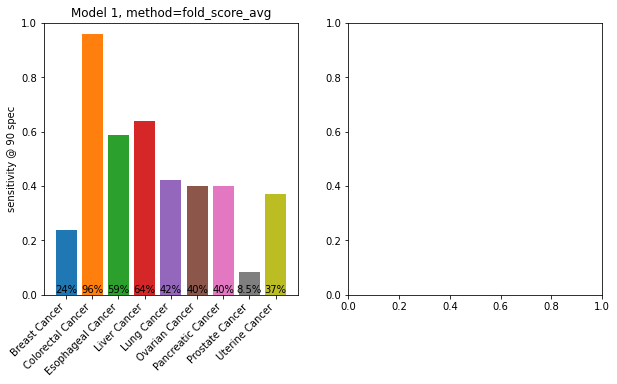

In [122]:
# one step. no combined transforer chains 
# ** need to modify scoring function to pull form col 1 of matirx

bucket = "freenome-user-data-bgould"
path = "Multi_cancer/Two_step_models/model_compare/outlier_chmfc_vp2_base" 
#df_sample_avg = generate_exp_table(bucket, path)
#base_model_scores = plot_multicancer_sensitivities(df_sample_avg, by_vote=False)
no_ctch_scores = scores_by_model(bucket,path, steps=1)

   sample_id    cancer_type     score
0       4943  Breast Cancer  0.000000
1       4953  Breast Cancer  0.187157
2       4957  Breast Cancer  0.000000
3       4991  Breast Cancer  0.000000
4       5006  Breast Cancer  0.000000


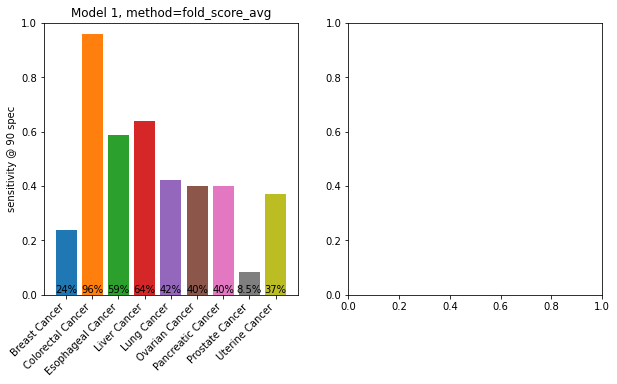

In [127]:
# baseline. outlier implemented within combined transformer chains.

bucket = "freenome-user-data-bgould"
path = "Multi_cancer/Two_step_models/model_compare/outlier_chmfc_vp2" 

#df_sample_avg = generate_exp_table(bucket, path)
#one_step_dict = plot_multicancer_sensitivities(df_sample_avg, by_vote=False)
base_scores = scores_by_model(bucket, path, steps=1)

Text(0, 0.5, 'no combined transformer chains')

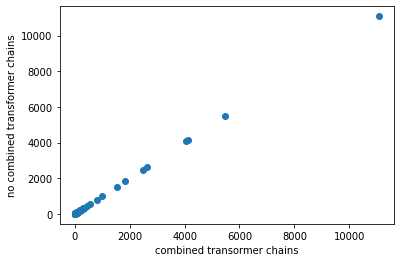

In [128]:
# plot baseline1 vs baseline2: outlier with and without combined transformer chains
x = []
y = []
for sid in no_ctch_scores.keys():
    x.append(base_scores[sid])
    #y.append(two_step_dict[sid])
    y.append(no_ctch_scores[sid])
plt.figure()
plt.scatter(x,y)
#plt.ylabel("two step model score")
plt.xlabel("combined transormer chains")
plt.ylabel("no combined transformer chains")

EXPERIMENT LOADER: Warning, single_spec = False so the hyperparameter search returns a best spec PER FOLD. Therefore `loader.spec` is only one of the best specs! To retrieve the best spec per fold do the following: `loader.fold('kfold_0').spec.pipeline_yaml`, `loader.fold('kfold_1').spec.pipeline_yaml`, etc.


CRC Sens: 0.9166666666666666
Other Cancer Sens: 0.3842696629213483


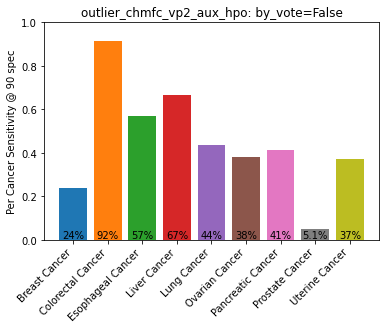

In [69]:
bucket = "freenome-user-data-bgould"
path = "Multi_cancer/Two_step_models/model_compare/outlier_chmfc_vp2_aux_hpo" # baseline. this is CRC vs. Healthy trained

df_sample_avg = generate_exp_table(bucket, path)
plot_multicancer_sensitivities(df_sample_avg, by_vote=False)

In [ ]:
bucket = "freenome-user-data-bgould"
path = "Multi_cancer/Two_step_models/model_compare/outlier_chmfc_MCreg" # trained CRC vs. Healthy

df_sample_avg = generate_exp_table(bucket, path)
plot_multicancer_sensitivities(df_sample_avg, by_vote=False)

In [ ]:
bucket = "freenome-user-data-bgould"
path = "Multi_cancer/Two_step_models/model_compare/outlier_chmfc_MC_aux_hpo" # trained CRC vs. Healthy

df_sample_avg = generate_exp_table(bucket, path)
plot_multicancer_sensitivities(df_sample_avg, by_vote=False)

In [ ]:
# this one is almost equivalent to the one we ran during the april readout
bucket = "freenome-user-data-bgould"
path = "Multi_cancer/Two_step_models/model_compare/outlier_chmfc_MC_aux2_hpo" # baseline. this is CRC vs. Healthy trained

df_sample_avg = generate_exp_table(bucket, path)
plot_multicancer_sensitivities(df_sample_avg, by_vote=False)

In [ ]:
bucket = "freenome-user-data-bgould"
path = "Multi_cancer/Two_step_models/model_compare/outlier_chmfc_crc_vs_all_vp2" # trained CRC vs. all other

df_sample_avg = generate_exp_table(bucket, path)
plot_multicancer_sensitivities(df_sample_avg, by_vote=False, spec=90)
plot_multicancer_sensitivities(df_sample_avg, by_vote=False, spec=99)
plot_multicancer_sensitivities(df_sample_avg, by_vote=False, spec=100)

# see plot at 99% spec > variation in rates. Samples are thresholded on Colorectal Healthy samples only. 
#What is going on here? With the extra samples, model calls all cancers correctly?

   sample_id                                   fold  y_true   y_score  \
0       4991  metadata_balanced_kfold_cancer_type_0       0 -0.220487   
1       5006  metadata_balanced_kfold_cancer_type_0       0 -0.220487   
2      14879  metadata_balanced_kfold_cancer_type_0       0 -0.220487   
3      20042  metadata_balanced_kfold_cancer_type_0       0 -0.220487   
4      20050  metadata_balanced_kfold_cancer_type_0       0 -0.220487   

                        status stage subtype  inference  fold_call  \
0                Breast Cancer     2    None      False          0   
1                Breast Cancer     2    None      False          0   
2  Colorectal Normal / Healthy  None    None      False          0   
3            Pancreatic Cancer     2    None      False          0   
4            Pancreatic Cancer     2    None      False          0   

   chain0_score  chain1_score  maj_vote_call  score_mean  chain0_score_mean  \
0     -0.123178     -0.164068              0   -0.211864     

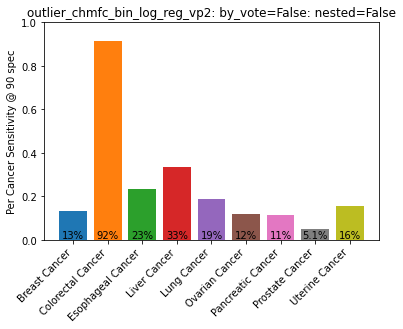

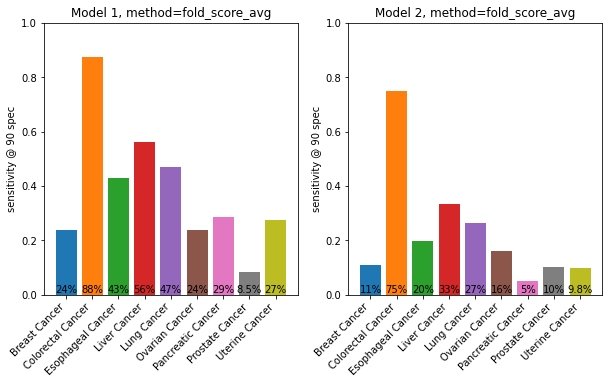

In [37]:
bucket = "freenome-user-data-bgould"
path = "Multi_cancer/Two_step_models/model_compare/outlier_chmfc_bin_log_reg_vp2" 

df_sample_avg = generate_exp_table(bucket, path, chains=2)
mean_scores_dict = plot_multicancer_sensitivities(df_sample_avg, by_vote=False)

sub_scores_dict = scores_by_model(bucket, path, steps=2)


In [ ]:
'''
How do we increase CRC sensitivity from model 1 to combined output?
Performance for step 1 here is based on standardized
scores from model 1 (std. scaler hurts outlier model performance), but performance of the combined model is 
based on fold_score averaging of fold scores that use combine_rule. Std. scaler seems to help reduce cross
reactivity but hurt crc sensitivity.
'''

In [105]:
def score_plot(mean_scores_dict, sub_scores_dict, path):
    sids = [k for k in mean_scores_dict.keys()]
    combined_scores = []
    chain1_scores = []
    chain2_scores = []
    types = []
    for sid in sids:
        types.append(mean_scores_dict[sid][0])
        combined_scores.append(mean_scores_dict[sid][1])
        chain1_scores.append(sub_scores_dict[sid][0])
        chain2_scores.append(sub_scores_dict[sid][1])
    
    def _log(scores):
        return np.log10(scores + 10)
    
    mask = [t in HEALTHY_TYPES for t in types]
    chain1_scores_healthies = _log(np.array(chain1_scores)[mask])
    chain2_scores_healthies = (_log(np.array(chain2_scores)[mask]))[np.argsort(chain1_scores_healthies)]
    combined_scores_healthies = (_log(np.array(combined_scores)[mask]))[np.argsort(chain1_scores_healthies)]
    chain1_scores_healthies = np.sort(chain1_scores_healthies)
    
    mask = [t == "Colorectal Cancer" for t in types]
    chain1_scores_crc = _log(np.array(chain1_scores)[mask])
    chain2_scores_crc = (_log(np.array(chain2_scores)[mask]))[np.argsort(chain1_scores_crc)]
    combined_scores_crc = (_log(np.array(combined_scores)[mask]))[np.argsort(chain1_scores_crc)]
    chain1_scores_crc = np.sort(chain1_scores_crc)
    
    mask = [t not in (["Colorectal Cancer"] + HEALTHY_TYPES) for t in types]
    chain1_scores_noncrc = _log(np.array(chain1_scores)[mask])
    chain2_scores_noncrc = (_log(np.array(chain2_scores)[mask]))[np.argsort(chain1_scores_noncrc)]
    combined_scores_noncrc = (_log(np.array(combined_scores)[mask]))[np.argsort(chain1_scores_noncrc)]
    chain1_scores_noncrc = np.sort(chain1_scores_noncrc)

    
    fig, ax = plt.subplots(figsize=(20,8))
    plt.title(os.path.basename(path))
    plt.ylabel("log10(model_score + 10)")
    ax.scatter(x = range(0, len(combined_scores_crc)), y=(combined_scores_crc),
               color="blue", marker="x", label="crc_combined")
    ax.scatter(x = range(len(combined_scores_crc), len(combined_scores_crc)+len(combined_scores_noncrc)),
               y = combined_scores_noncrc,
               color="blue", marker="v", label="noncrc_combined")
    ax.scatter(x = range(len(combined_scores_crc) + len(combined_scores_noncrc), len(combined_scores_crc)+len(combined_scores_noncrc) + len(combined_scores_healthies)),
               y = combined_scores_healthies,
               color="blue", marker="o", label="healthy_combined")
    
    ax.scatter(x = range(0, len(chain1_scores_crc)), y=(chain1_scores_crc),
               color="orange", marker="x", label="crc_chain1")
    ax.scatter(x = range(len(chain1_scores_crc), len(chain1_scores_crc)+len(chain1_scores_noncrc)),
               y = chain1_scores_noncrc,
               color="orange", marker="v", label="noncrc_chain1")
    ax.scatter(x = range(len(chain1_scores_crc) + len(chain1_scores_noncrc), len(chain1_scores_crc)+len(chain1_scores_noncrc) + len(chain1_scores_healthies)),
               y = chain1_scores_healthies,
               color="orange", marker="o", label="healthy_chain1")
    
    ax.scatter(x = range(0, len(chain2_scores_crc)), y=(chain2_scores_crc),
               color="green", marker="x", label="crc_chain2")
    ax.scatter(x = range(len(chain2_scores_crc), len(chain2_scores_crc)+len(chain2_scores_noncrc)),
               y = chain2_scores_noncrc,
               color="green", marker="v", label="noncrc_chain2")
    ax.scatter(x = range(len(chain2_scores_crc) + len(chain2_scores_noncrc), len(chain2_scores_crc)+len(chain2_scores_noncrc) + len(chain2_scores_healthies)),
               y = chain2_scores_healthies,
               color="green", marker="o", label="healthy_chain2")
    
    plt.hlines(y=np.percentile(combined_scores_healthies, 90), color="blue", xmin=0, xmax=800, linestyle="--")
    plt.hlines(y=np.percentile(chain1_scores_healthies, 90), color="orange", xmin=0, xmax=800, linestyle="--")
    plt.hlines(y=np.percentile(chain2_scores_healthies, 90), color="green", xmin=0, xmax=800, linestyle="--")
    #plt.ylim((-1,6))
    plt.legend()

   sample_id                                   fold  y_true   y_score  \
0       4991  metadata_balanced_kfold_cancer_type_0       0 -0.220487   
1       5006  metadata_balanced_kfold_cancer_type_0       0 -0.220487   
2      14879  metadata_balanced_kfold_cancer_type_0       0 -0.220487   
3      20042  metadata_balanced_kfold_cancer_type_0       0 -0.220487   
4      20050  metadata_balanced_kfold_cancer_type_0       0 -0.220487   

                        status stage_x subtype  inference  fold_call stage_y  \
0                Breast Cancer       2    None      False          0     IIB   
1                Breast Cancer       2    None      False          0     IIB   
2  Colorectal Normal / Healthy    None    None      False          0    None   
3            Pancreatic Cancer       2    None      False          0     IIA   
4            Pancreatic Cancer       2    None      False          0     IIB   

   chain0_score  chain1_score  maj_vote_call  score_mean  chain0_score_mean  \
0

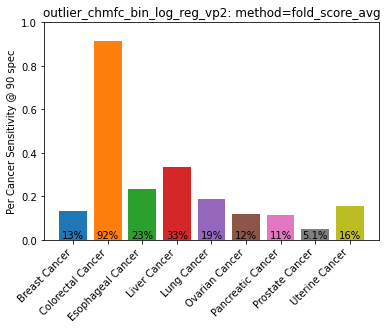

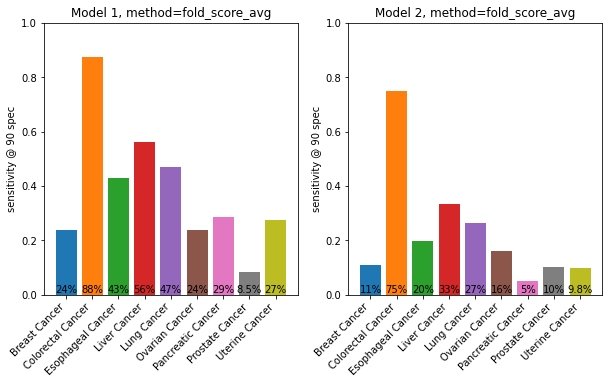

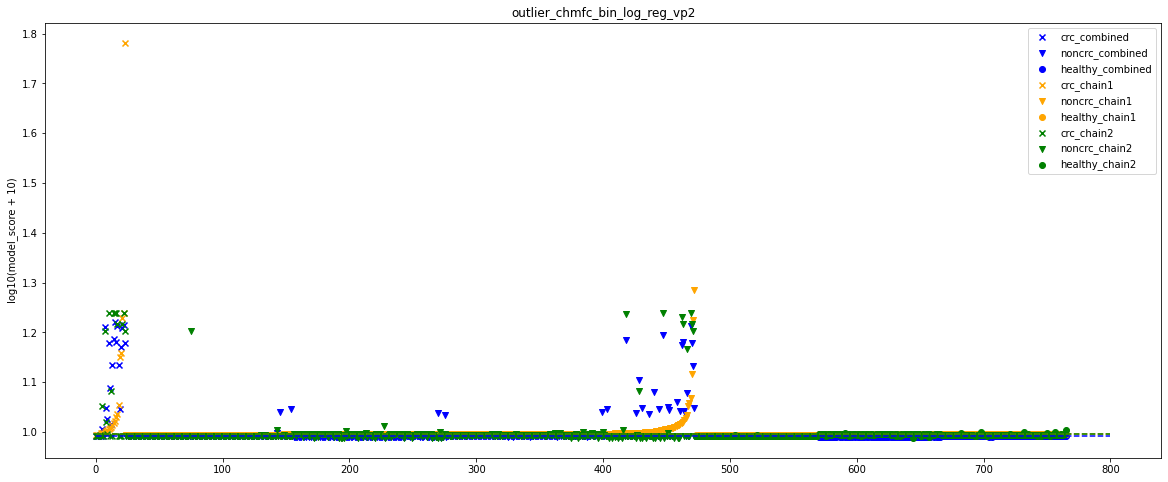

In [106]:
path = "Multi_cancer/Two_step_models/model_compare/outlier_chmfc_bin_log_reg_vp2" 

df_sample_avg = generate_exp_table(bucket, path, chains=2)
mean_scores_dict = plot_multicancer_sensitivities(df_sample_avg, method="fold_score_avg")

sub_scores_dict = scores_by_model(bucket, path, steps=2)

score_plot(mean_scores_dict, sub_scores_dict, path)

   sample_id                                   fold  y_true   y_score  \
0       4991  metadata_balanced_kfold_cancer_type_0       0 -0.188041   
1       5006  metadata_balanced_kfold_cancer_type_0       0 -0.188041   
2      14879  metadata_balanced_kfold_cancer_type_0       0 -0.188041   
3      20042  metadata_balanced_kfold_cancer_type_0       0 -0.188041   
4      20050  metadata_balanced_kfold_cancer_type_0       0 -0.188041   

                        status stage subtype  inference  fold_call  \
0                Breast Cancer     2    None      False          0   
1                Breast Cancer     2    None      False          0   
2  Colorectal Normal / Healthy  None    None      False          0   
3            Pancreatic Cancer     2    None      False          0   
4            Pancreatic Cancer     2    None      False          0   

   chain0_score  chain1_score  maj_vote_call  score_mean  chain0_score_mean  \
0     -0.123178     -0.175900              1   -0.194469     

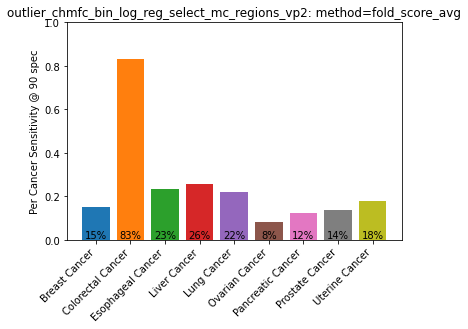

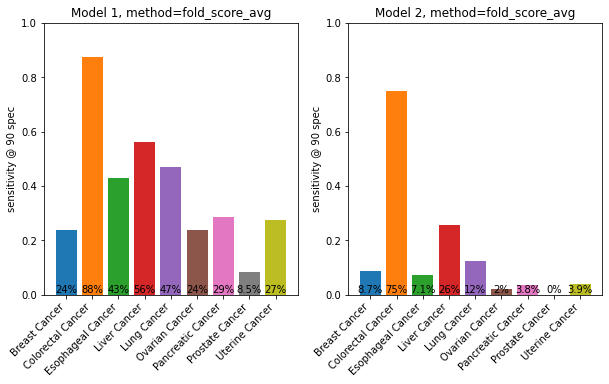

In [138]:
path = "Multi_cancer/Two_step_models/model_compare/outlier_chmfc_bin_log_reg_select_mc_regions_vp2" 

df_sample_avg = generate_exp_table(bucket, path, chains=2)
mean_scores_dict = plot_multicancer_sensitivities(df_sample_avg, method="fold_score_avg")
sub_scores_dict = scores_by_model(bucket, path, steps=2)

   sample_id                                   fold  y_true       y_score  \
0       4991  metadata_balanced_kfold_cancer_type_0       0  1.828690e-51   
1       5006  metadata_balanced_kfold_cancer_type_0       0  1.828690e-51   
2      14879  metadata_balanced_kfold_cancer_type_0       0  1.828690e-51   
3      20042  metadata_balanced_kfold_cancer_type_0       0  1.828690e-51   
4      20050  metadata_balanced_kfold_cancer_type_0       0  1.828690e-51   

                        status stage subtype  inference  fold_call  \
0                Breast Cancer     2    None      False          0   
1                Breast Cancer     2    None      False          0   
2  Colorectal Normal / Healthy  None    None      False          0   
3            Pancreatic Cancer     2    None      False          0   
4            Pancreatic Cancer     2    None      False          0   

   chain0_score  maj_vote_call    score_mean  chain0_score_mean  
0       0.00000              0  3.657381e-52      

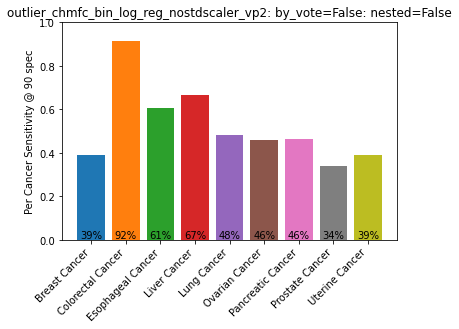

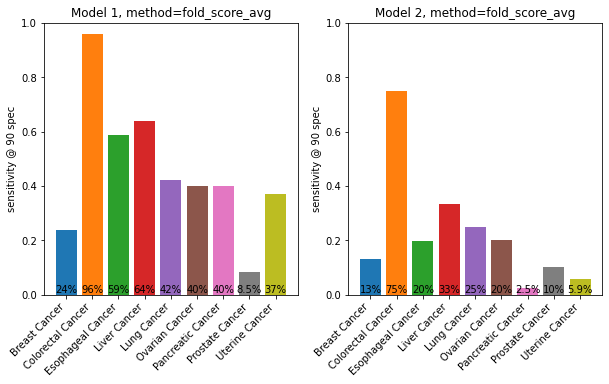

In [73]:

bucket = "freenome-user-data-bgould"
path = "Multi_cancer/Two_step_models/model_compare/outlier_chmfc_bin_log_reg_nostdscaler_vp2" 

df_sample_avg = generate_exp_table(bucket, path)
plot_multicancer_sensitivities(df_sample_avg, by_vote=False)
two_step_dict = scores_by_model(bucket, path, steps=2)

Text(0.5, 0, 'two step model score')

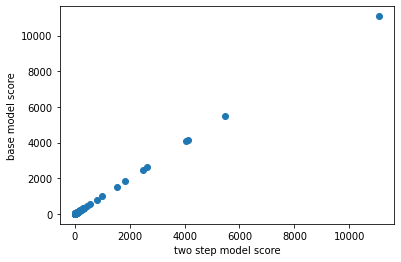

In [132]:
# compare two step model w base model
x = []
y = []
for sid in one_step_dict.keys():
    x.append(two_step_dict[sid])
    #y.append(two_step_dict[sid])
    y.append(base_scores[sid])
plt.figure()
plt.scatter(x,y)
#plt.ylabel("two step model score")
plt.ylabel("base model score")
plt.xlabel("two step model score")

CRC Sens: 0.75
Other Cancer Sens: 0.21123595505617979


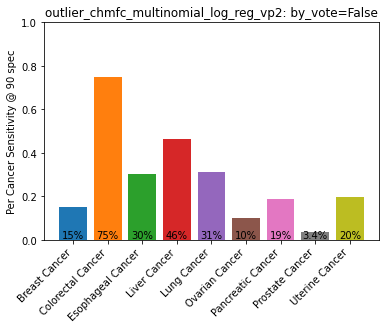

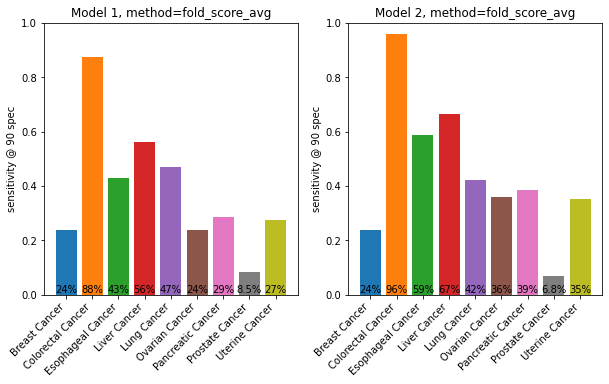

In [65]:
bucket = "freenome-user-data-bgould"
path = "Multi_cancer/Two_step_models/model_compare/outlier_chmfc_multinomial_log_reg_vp2" 

df_sample_avg = generate_exp_table(bucket, path, chains=2)
plot_multicancer_sensitivities(df_sample_avg, by_vote=False, method="by_fold")
scores_by_model(bucket, path)

CRC Sens: 0.7083333333333334
Other Cancer Sens: 0.17752808988764046


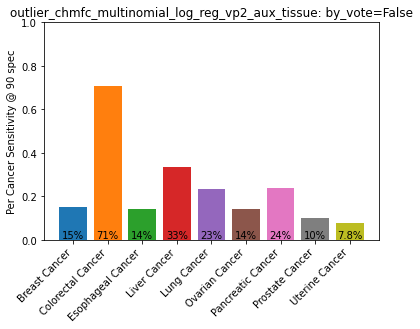

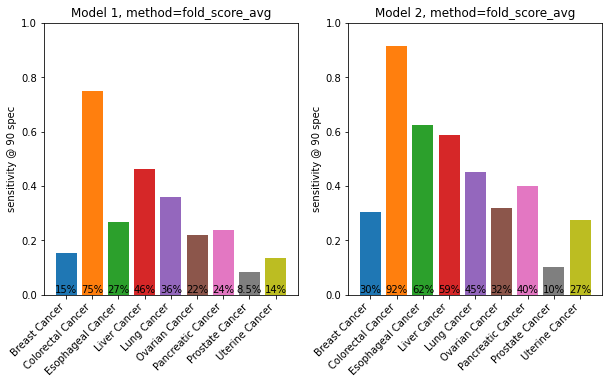

In [66]:
bucket = "freenome-user-data-bgould"
path = "Multi_cancer/Two_step_models/model_compare/outlier_chmfc_multinomial_log_reg_vp2_aux_tissue" 

df_sample_avg = generate_exp_table(bucket, path)
plot_multicancer_sensitivities(df_sample_avg, by_vote=False)
scores_by_model(bucket, path)

In [23]:

bucket = "freenome-user-data-bgould"
path = "Multi_cancer/Two_step_models/model_compare/outlier_chmfc_multinomial_histogram_vp2" 

df_sample_avg = generate_exp_table(bucket, path, chains=2)
plot_multicancer_sensitivities(df_sample_avg, by_vote=False, chains=2, method="by_fold")
#scores_by_model(bucket, path)

(256, 2)
(255, 2)
(255, 2)
(256, 2)
(255, 2)
(255, 2)
(256, 2)
(255, 2)
(255, 2)
(256, 2)
(255, 2)
(255, 2)
(256, 2)
(255, 2)
(255, 2)
   sample_id                                   fold  y_true   y_score  \
0       4991  metadata_balanced_kfold_cancer_type_0       0 -0.179967   
1       5006  metadata_balanced_kfold_cancer_type_0       0 -0.179967   
2      14879  metadata_balanced_kfold_cancer_type_0       0 -0.179967   
3      20042  metadata_balanced_kfold_cancer_type_0       0 -0.179967   
4      20050  metadata_balanced_kfold_cancer_type_0       0 -0.179967   

                        status stage subtype  inference  fold_call  \
0                Breast Cancer     2    None      False          0   
1                Breast Cancer     2    None      False          0   
2  Colorectal Normal / Healthy  None    None      False          0   
3            Pancreatic Cancer     2    None      False          0   
4            Pancreatic Cancer     2    None      False          0   

   ch

TypeError: plot_multicancer_sensitivities() got an unexpected keyword argument 'chains'

CRC Sens: 0.7916666666666666
Other Cancer Sens: 0.02247191011235955


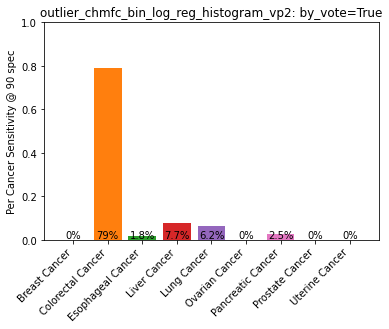

In [76]:

bucket = "freenome-user-data-bgould"
path = "Multi_cancer/Two_step_models/model_compare/outlier_chmfc_bin_log_reg_histogram_vp2" 

df_sample_avg = generate_exp_table(bucket, path)
plot_multicancer_sensitivities(df_sample_avg, by_vote=True)

CRC Sens: 0.75
Other Cancer Sens: 0.16404494382022472


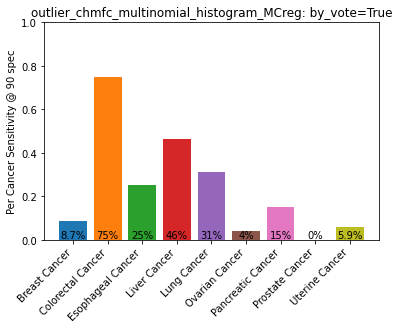

In [77]:
bucket = "freenome-user-data-bgould"
path = "Multi_cancer/Two_step_models/model_compare/outlier_chmfc_multinomial_histogram_MCreg" # LONG runtime

df_sample_avg = generate_exp_table(bucket, path)
plot_multicancer_sensitivities(df_sample_avg, by_vote=True)

   sample_id                                   fold  y_true   y_score  \
0       4991  metadata_balanced_kfold_cancer_type_0       0 -0.179967   
1       5006  metadata_balanced_kfold_cancer_type_0       0 -0.179967   
2      14879  metadata_balanced_kfold_cancer_type_0       0 -0.179967   
3      20042  metadata_balanced_kfold_cancer_type_0       0 -0.179967   
4      20050  metadata_balanced_kfold_cancer_type_0       0 -0.179967   

                        status stage subtype  inference  fold_call  \
0                Breast Cancer     2    None      False          1   
1                Breast Cancer     2    None      False          1   
2  Colorectal Normal / Healthy  None    None      False          1   
3            Pancreatic Cancer     2    None      False          1   
4            Pancreatic Cancer     2    None      False          1   

   chain0_score  chain1_score  maj_vote_call  score_mean  chain0_score_mean  \
0     -0.123178     -0.179967              1   -0.179823     

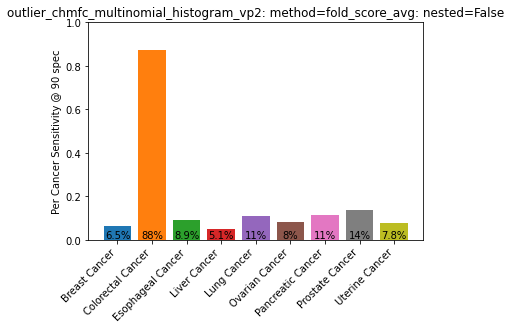

In [87]:
bucket = "freenome-user-data-bgould"
path = "Multi_cancer/Two_step_models/model_compare/outlier_chmfc_multinomial_histogram_vp2" # LONG runtime

df_sample_avg = generate_exp_table(bucket, path, chains=2)
_ = plot_multicancer_sensitivities(df_sample_avg, method="fold_score_avg")

   sample_id                                   fold  y_true   y_score  \
0       4991  metadata_balanced_kfold_cancer_type_0       0 -0.424332   
1       5006  metadata_balanced_kfold_cancer_type_0       0 -0.424332   
2      14879  metadata_balanced_kfold_cancer_type_0       0 -0.424332   
3      20042  metadata_balanced_kfold_cancer_type_0       0 -0.424332   
4      20050  metadata_balanced_kfold_cancer_type_0       0 -0.424332   

                        status stage subtype  inference  fold_call  \
0                Breast Cancer     2    None      False          1   
1                Breast Cancer     2    None      False          1   
2  Colorectal Normal / Healthy  None    None      False          1   
3            Pancreatic Cancer     2    None      False          1   
4            Pancreatic Cancer     2    None      False          1   

   chain0_score  chain1_score  maj_vote_call  score_mean  chain0_score_mean  \
0     -0.123178     -0.424332              1   -0.426331     

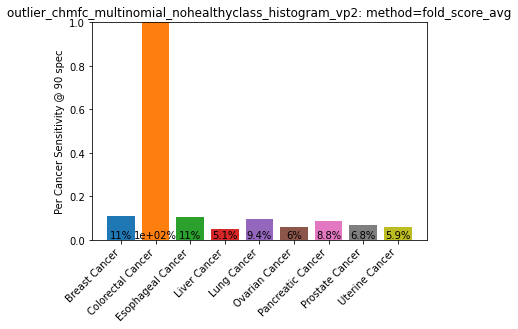

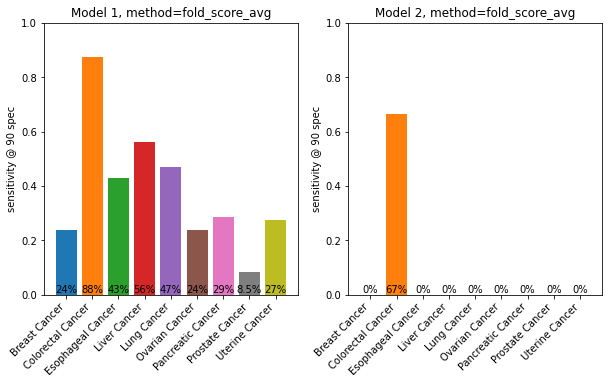

In [133]:

bucket = "freenome-user-data-bgould"
path = "Multi_cancer/Two_step_models/model_compare/outlier_chmfc_multinomial_nohealthyclass_histogram_vp2" # LONG runtime

df_sample_avg = generate_exp_table(bucket, path, chains=2)
_ = plot_multicancer_sensitivities(df_sample_avg, method="fold_score_avg")
_ = scores_by_model(bucket, path)

In [130]:
def get_confusion_matrix(bucket, path):
    loader = ExperimentLoader(bucket,path)
    dfs_2 = []
    for fold_name in loader.fold_names():
        fold_loader = loader.fold(fold_name)
        test_sids = fold_loader.post_transformer_fold_holder.test.sample_ids
        chain_scores = fold_loader.post_transformer_fold_holder['mint-chmcfc-VP2-intersect-CpGV2-dsc_v1/v1'].test.x
        #print(chain_scores[0:5,0:5])
        test_cancer_type = [m.cancer_type for m in fold_loader.post_transformer_fold_holder.test.sample_metadata]
        combine_chains = fold_loader._pipeline_result.pipeline.transformer_chains['mint-chmcfc-VP2-intersect-CpGV2-dsc_v1/v1'][0]
        mult_class_model = combine_chains.transformer_chains[1][2]
        classes = [
            mult_class_model.class0,
            mult_class_model.class1,
            mult_class_model.class2,
            mult_class_model.class3,
            mult_class_model.class4,
            mult_class_model.class5,
            mult_class_model.class6,
            mult_class_model.class7,
            mult_class_model.class8,
            mult_class_model.class9,
            mult_class_model.class10,
        ]
        classes_str = [
            "class0",
            "class1",
            "class2",
            "class3",
            "class4",
            "class5",
            "class6",
            "class7",
            "class8",
            "class9",
            "class10",
        ]
        classes_dict = dict(zip(classes_str, classes))
        TOO_calls = [classes_dict[cl][0] for cl in mult_class_model.TOO_calls]
        dfs_2.append(pd.DataFrame.from_dict({"sample_id":test_sids, 
                                               "fold":[fold_name]*len(test_sids),
                                               "cancer_type": test_cancer_type,
                                               "score": chain_scores[:,1],
                                              "TOO_call": TOO_calls}))
    df2 = pd.concat(dfs_2, axis=0)
    print(df2.head())
    
    df2_cancers = df2[[ct in CANCER_TYPES for ct in df2["cancer_type"]]]
    y = df2_cancers["cancer_type"]
    y_pred = df2_cancers["TOO_call"]
    combos = list(zip(y, y_pred))
    #print(y_pred)
    matches = []
    tp_counts = []
    for i in np.unique(y):
        matrix_row = []
        for j in np.unique(y_pred):
            matrix_row.append(combos.count((i,j)))
            if i==j:
                tp_counts.append(combos.count((i,j)))
        matches.append(matrix_row)
    arr_matches = np.array(matches)
    percents = arr_matches / arr_matches.sum(axis=1, keepdims=True)
    df_matches = pd.DataFrame(arr_matches, columns=np.unique(y_pred),index=np.unique(y))
    df_percents = pd.DataFrame(percents, columns=np.unique(y_pred),index=np.unique(y))
    #print(percents.shape)
    #print(df_matches.shape)
    
    plt.figure()
    ax = sns.heatmap(df_percents, annot=df_matches, cmap="GnBu", fmt='.0f')
    plt.title(os.path.basename(path), size=16)
    ax.set_xlabel("Predicted Label", size=14)
    ax.set_ylabel("True Label", size=14)
    print(f"Overall accuracy: {float(np.sum(tp_counts)) / df_matches.sum().sum()}")
    
    return #df_matches

   sample_id                                   fold  \
0       4991  metadata_balanced_kfold_cancer_type_0   
1       5006  metadata_balanced_kfold_cancer_type_0   
2      14879  metadata_balanced_kfold_cancer_type_0   
3      20042  metadata_balanced_kfold_cancer_type_0   
4      20050  metadata_balanced_kfold_cancer_type_0   

                   cancer_type     score           TOO_call  
0                Breast Cancer -0.424332      Breast Cancer  
1                Breast Cancer -0.424332     Ovarian Cancer  
2  Colorectal Normal / Healthy -0.424332  Pancreatic Cancer  
3            Pancreatic Cancer -0.424332      Breast Cancer  
4            Pancreatic Cancer -0.424332  Pancreatic Cancer  
Overall accuracy: 0.33646055437100214


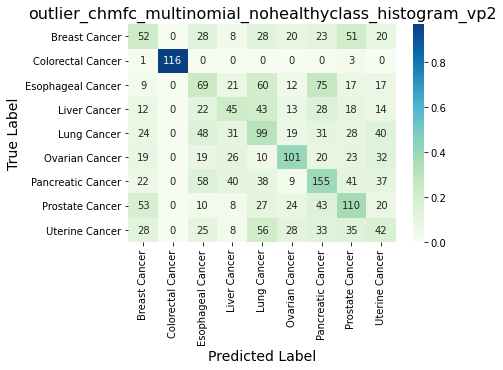

In [131]:
path = "Multi_cancer/Two_step_models/model_compare/outlier_chmfc_multinomial_nohealthyclass_histogram_vp2"

df_matches = get_confusion_matrix(bucket, path)

   sample_id                                   fold  y_true  y_score  \
0       4991  metadata_balanced_kfold_cancer_type_0       0 -0.19128   
1       5006  metadata_balanced_kfold_cancer_type_0       0 -0.19128   
2      14879  metadata_balanced_kfold_cancer_type_0       0 -0.19128   
3      20042  metadata_balanced_kfold_cancer_type_0       0 -0.19128   
4      20050  metadata_balanced_kfold_cancer_type_0       0 -0.19128   

                        status stage subtype  inference  fold_call  \
0                Breast Cancer     2    None      False          0   
1                Breast Cancer     2    None      False          0   
2  Colorectal Normal / Healthy  None    None      False          0   
3            Pancreatic Cancer     2    None      False          0   
4            Pancreatic Cancer     2    None      False          0   

   chain0_score  chain1_score  maj_vote_call  score_mean  chain0_score_mean  \
0     -0.123178     -0.190877              1   -0.186592          -

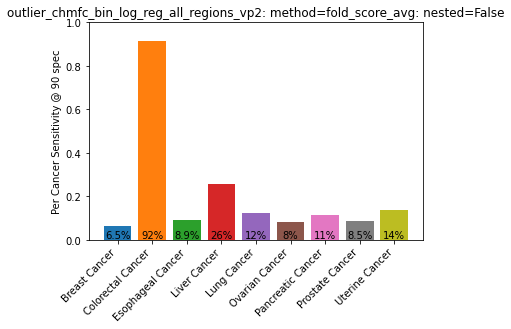

In [85]:

bucket = "freenome-user-data-bgould"
path = "Multi_cancer/Two_step_models/model_compare/outlier_chmfc_bin_log_reg_all_regions_vp2" 

df_sample_avg = generate_exp_table(bucket, path, chains=2)
#plot_multicancer_sensitivities(df_sample_avg, by_vote=True)
_ = plot_multicancer_sensitivities(df_sample_avg, method="fold_score_avg")

CRC Sens: 0.4583333333333333
Other Cancer Sens: 0.01348314606741573
CRC Sens: 0.875
Other Cancer Sens: 0.2539325842696629


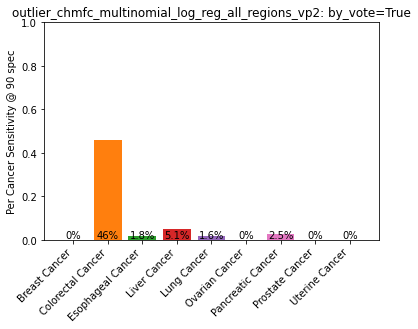

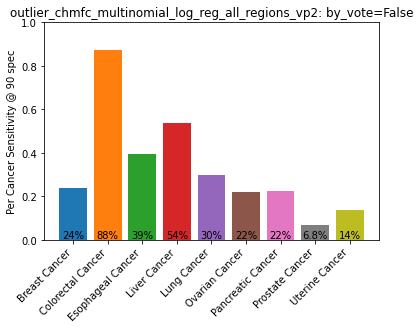

In [90]:

bucket = "freenome-user-data-bgould"
path = "Multi_cancer/Two_step_models/model_compare/outlier_chmfc_multinomial_log_reg_all_regions_vp2" 

df_sample_avg = generate_exp_table(bucket, path, chains=2)
#plot_multicancer_sensitivities(df_sample_avg, by_vote=True)
plot_multicancer_sensitivities(df_sample_avg, by_vote=False, nested=)

In [ ]:

bucket = "freenome-user-data-bgould"
path = "Multi_cancer/Two_step_models/model_compare/outlier_chmfc_bin_log_reg_all_regions_MCreg" 

df_sample_avg = generate_exp_table(bucket, path)
plot_multicancer_sensitivities(df_sample_avg, by_vote=True)
plot_multicancer_sensitivities(df_sample_avg, by_vote=False)

   sample_id                                   fold  y_true  y_score  \
0       4991  metadata_balanced_kfold_cancer_type_0       0 -0.19128   
1       5006  metadata_balanced_kfold_cancer_type_0       0 -0.19128   
2      14879  metadata_balanced_kfold_cancer_type_0       0 -0.19128   
3      20042  metadata_balanced_kfold_cancer_type_0       0 -0.19128   
4      20050  metadata_balanced_kfold_cancer_type_0       0 -0.19128   

                        status stage subtype  inference  fold_call  \
0                Breast Cancer     2    None      False          0   
1                Breast Cancer     2    None      False          0   
2  Colorectal Normal / Healthy  None    None      False          0   
3            Pancreatic Cancer     2    None      False          0   
4            Pancreatic Cancer     2    None      False          0   

   chain0_score  chain1_score  maj_vote_call  score_mean  chain0_score_mean  \
0     -0.123178     -0.190877              1   -0.186592          -

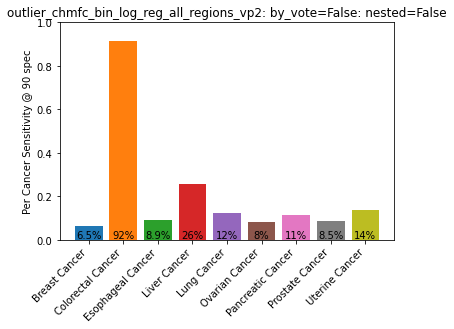

In [18]:
bucket = "freenome-user-data-bgould"
path = "Multi_cancer/Two_step_models/model_compare/outlier_chmfc_bin_log_reg_all_regions_vp2" 
# not nested
df_sample_avg = generate_exp_table(bucket, path, chains=2)
plot_multicancer_sensitivities(df_sample_avg, by_vote=False, nested=False)

(256, 2)
(255, 2)
(255, 2)
(256, 2)
(255, 2)
(255, 2)
(256, 2)
(255, 2)
(255, 2)
(256, 2)
(255, 2)
(255, 2)
(256, 2)
(255, 2)
(255, 2)
   sample_id                                   fold  y_true       y_score  \
0       4991  metadata_balanced_kfold_cancer_type_0       0  1.861696e-74   
1       5006  metadata_balanced_kfold_cancer_type_0       0  1.861696e-74   
2      14879  metadata_balanced_kfold_cancer_type_0       0  1.861696e-74   
3      20042  metadata_balanced_kfold_cancer_type_0       0  1.861696e-74   
4      20050  metadata_balanced_kfold_cancer_type_0       0  1.861696e-74   

                        status stage subtype  inference  fold_call  \
0                Breast Cancer     2    None      False          0   
1                Breast Cancer     2    None      False          0   
2  Colorectal Normal / Healthy  None    None      False          0   
3            Pancreatic Cancer     2    None      False          0   
4            Pancreatic Cancer     2    None      Fa

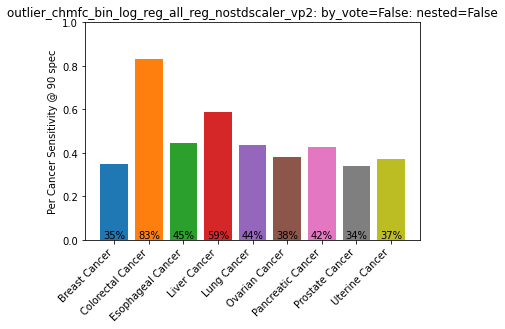

In [20]:

bucket = "freenome-user-data-bgould"
path = "Multi_cancer/Two_step_models/model_compare/outlier_chmfc_bin_log_reg_all_reg_nostdscaler_vp2" 
# not nested
df_sample_avg = generate_exp_table(bucket, path, chains=2)
plot_multicancer_sensitivities(df_sample_avg, by_vote=False, nested=False)

   sample_id                                   fold  y_true       y_score  \
0       4991  metadata_balanced_kfold_cancer_type_0       0  1.861696e-74   
1       5006  metadata_balanced_kfold_cancer_type_0       0  1.861696e-74   
2      14879  metadata_balanced_kfold_cancer_type_0       0  1.861696e-74   
3      20042  metadata_balanced_kfold_cancer_type_0       0  1.861696e-74   
4      20050  metadata_balanced_kfold_cancer_type_0       0  1.861696e-74   

                        status stage subtype  inference  fold_call  \
0                Breast Cancer     2    None      False          1   
1                Breast Cancer     2    None      False          1   
2  Colorectal Normal / Healthy  None    None      False          1   
3            Pancreatic Cancer     2    None      False          1   
4            Pancreatic Cancer     2    None      False          1   

   chain0_score  chain1_score  maj_vote_call    score_mean  chain0_score_mean  \
0       0.00000  6.528686e-05      

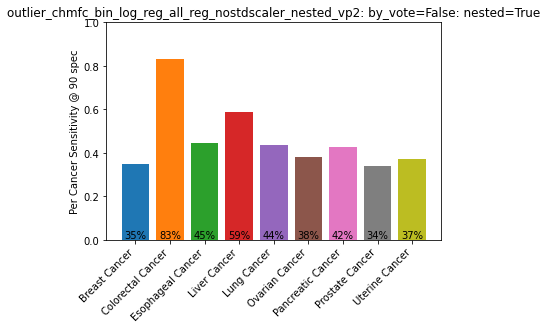

In [17]:
bucket = "freenome-user-data-bgould"
# nested
path = "Multi_cancer/Two_step_models/model_compare/outlier_chmfc_bin_log_reg_all_reg_nostdscaler_nested_vp2" 

df_sample_avg = generate_exp_table(bucket, path, chains=2)
plot_multicancer_sensitivities(df_sample_avg, by_vote=False, nested=True)

(256, 2)
(255, 2)
(255, 2)
(256, 2)
(255, 2)
(255, 2)
(256, 2)
(255, 2)
(255, 2)
(256, 2)
(255, 2)
(255, 2)
(256, 2)
(255, 2)
(255, 2)
   sample_id                                   fold  y_true   y_score  \
0       4991  metadata_balanced_kfold_cancer_type_0       0  0.000000   
1       5006  metadata_balanced_kfold_cancer_type_0       0  0.000000   
2      14879  metadata_balanced_kfold_cancer_type_0       0  0.989159   
3      20042  metadata_balanced_kfold_cancer_type_0       0  0.000000   
4      20050  metadata_balanced_kfold_cancer_type_0       0  0.000000   

                        status stage subtype  inference  fold_call  \
0                Breast Cancer     2    None      False          0   
1                Breast Cancer     2    None      False          0   
2  Colorectal Normal / Healthy  None    None      False          1   
3            Pancreatic Cancer     2    None      False          0   
4            Pancreatic Cancer     2    None      False          0   

   ch

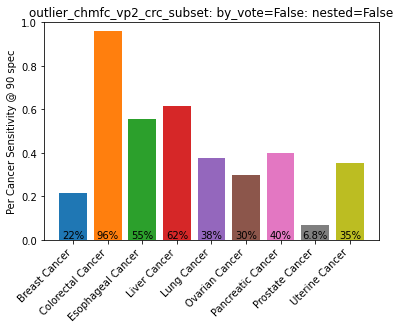

In [21]:
bucket = "freenome-user-data-bgould"
path = "Multi_cancer/Two_step_models/model_compare/outlier_chmfc_vp2_crc_subset" 

df_sample_avg = generate_exp_table(bucket, path, chains=1)
plot_multicancer_sensitivities(df_sample_avg, by_vote=False, nested=False)


   sample_id                                   fold  y_true   y_score  \
0       4991  metadata_balanced_kfold_cancer_type_0       0 -3.439557   
1       5006  metadata_balanced_kfold_cancer_type_0       0 -3.439557   
2      14879  metadata_balanced_kfold_cancer_type_0       0 -3.439557   
3      20042  metadata_balanced_kfold_cancer_type_0       0 -3.439557   
4      20050  metadata_balanced_kfold_cancer_type_0       0 -3.439557   

                        status stage subtype  inference  fold_call  \
0                Breast Cancer     2    None      False          0   
1                Breast Cancer     2    None      False          0   
2  Colorectal Normal / Healthy  None    None      False          0   
3            Pancreatic Cancer     2    None      False          0   
4            Pancreatic Cancer     2    None      False          0   

   chain0_score  chain1_score  maj_vote_call  score_mean  chain0_score_mean  \
0     -0.123178     -0.477585              1   -3.624079     

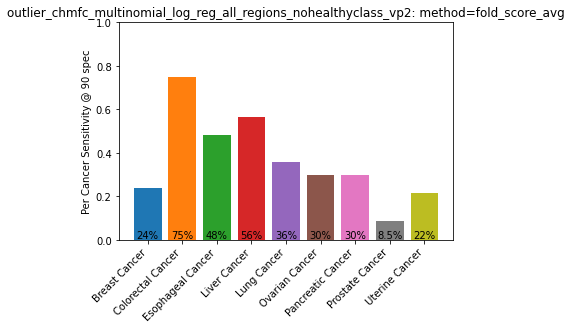

In [140]:

path = "Multi_cancer/Two_step_models/model_compare/outlier_chmfc_multinomial_log_reg_all_regions_nohealthyclass_vp2" 

df_sample_avg = generate_exp_table(bucket, path, chains=2)
_ = plot_multicancer_sensitivities(df_sample_avg, method="fold_score_avg", nested=False)

   sample_id                                   fold  y_true   y_score  \
0       4991  metadata_balanced_kfold_cancer_type_0       0 -8.721986   
1       5006  metadata_balanced_kfold_cancer_type_0       0 -8.721986   
2      14879  metadata_balanced_kfold_cancer_type_0       0 -8.721986   
3      20042  metadata_balanced_kfold_cancer_type_0       0 -8.721986   
4      20050  metadata_balanced_kfold_cancer_type_0       0 -8.721986   

                        status stage_x subtype  inference  fold_call stage_y  \
0                Breast Cancer       2    None      False          0     IIB   
1                Breast Cancer       2    None      False          0     IIB   
2  Colorectal Normal / Healthy    None    None      False          0    None   
3            Pancreatic Cancer       2    None      False          0     IIA   
4            Pancreatic Cancer       2    None      False          0     IIB   

   chain0_score  chain1_score  maj_vote_call  score_mean  chain0_score_mean  \
0

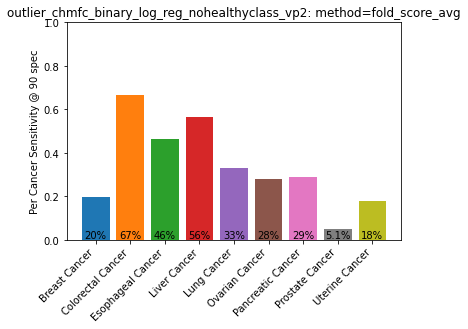

In [90]:

path = "Multi_cancer/Two_step_models/model_compare/outlier_chmfc_binary_log_reg_nohealthyclass_vp2" 

df_sample_avg = generate_exp_table(bucket, path, chains=2)
_ = plot_multicancer_sensitivities(df_sample_avg, method="fold_score_avg", nested=False)

# add CRC at other stages

In [141]:
from calzone import Calzone

In [142]:
def crc_sens_by_stage(path, df, method="fold_score_avg", chains=2):
    '''
    input a sample by fold table or a sample averages table
    '''
    df_crc = df[[t in ["Colorectal Cancer", "Colorectal Pre-Cancer"] for t in df["status"]]] # this should include CRC and AA
    sens = []
    labels = []
    sen_counts = []
#     stages = np.unique(df_crc["stage_x"])
    stages_str = ['AA','1','2','3','4']
#     if any([s not in stages_str for s in stages]):
#         print(f"WARNING: Unknown stage. Got {stages}")
    for stage in stages_str:
        if stage == 'AA':
            df_stage = df_crc[df_crc["status"]=="Colorectal Pre-Cancer"]
        else:
            df_stage = df_crc[df_crc["stage_x"]==stage]
        
        if len(df_stage) == 0:
            continue
        if method == "fold_score_avg":
            tps = list(df_stage["call90"].values).count(1)
        elif method == "by_fold":
            tps = list(df_stage["fold_call"].values).count(1)
        
        tot = float(len(df_stage))
        sen_final = tps / tot
        sen_counts.append((tps, tot))
        sens.append(sen_final)
        labels.append(f"CRC-{stage}\n(n={len(df_stage)})")
    
    tot_sen = np.sum([x[0] for x in sen_counts]) / float(np.sum([x[1] for x in sen_counts]))
    fig, ax = plt.subplots(figsize=(8,5))
    x = np.array(range(len(labels)))
    ax.bar(x, sens, color="blue", label="stage sens.")
    ax.bar(x[-1] + 1, tot_sen, color = "lightblue", label="total sens.")
    
    pos = list(range(len(labels) + 1))
    labs = list(labels) + ["Total"]
    plt.xticks(pos, labs)
    ax.set_ylabel("Sensitivity @90 spec.")
    #plt.xticks((x + width), labels)
    plt.ylim((0,1.0))
    plt.title(f"{os.path.basename(path)}, method:{method}")
   # add bar labels
    #sens = [ s for sublist in sens for s in sublist]
    for rect, sen in zip(ax.patches, sens + [tot_sen]):
        height = 0
        ax.text(rect.get_x() + rect.get_width() / 2, height, f"{(sen*100):.0f}%", ha="center", va="bottom")
    plt.legend()

   sample_id                                   fold  y_true   y_score  \
0       4991  metadata_balanced_kfold_cancer_type_0       0  0.000000   
1       5006  metadata_balanced_kfold_cancer_type_0       0  0.000000   
2      14879  metadata_balanced_kfold_cancer_type_0       0  1.009082   
3      20042  metadata_balanced_kfold_cancer_type_0       0  0.000000   
4      20050  metadata_balanced_kfold_cancer_type_0       0  0.000000   

                        status stage_x subtype  inference  fold_call stage_y  \
0                Breast Cancer       2    None      False          0     IIB   
1                Breast Cancer       2    None      False          0     IIB   
2  Colorectal Normal / Healthy    None    None      False          1    None   
3            Pancreatic Cancer       2    None      False          0     IIA   
4            Pancreatic Cancer       2    None      False          0     IIB   

   chain0_score  chain1_score  maj_vote_call  score_mean  chain0_score_mean  \
0

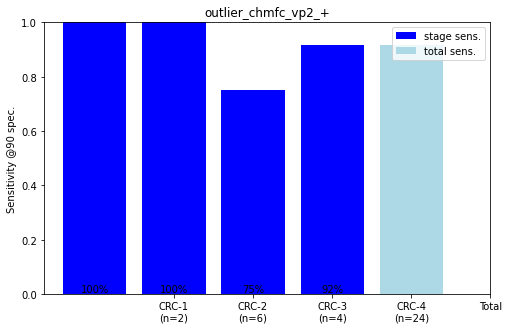

In [100]:
# baseline model
path = "Multi_cancer/Two_step_models/model_compare/more_crcs/outlier_chmfc_vp2_+" 

df_sample_avg = generate_exp_table(bucket, path, chains=2, spec=90)
crc_sens_by_stage(path, df_sample_avg)

   sample_id                                   fold  y_true   y_score  \
0       4991  metadata_balanced_kfold_cancer_type_0       0  0.000000   
1       5006  metadata_balanced_kfold_cancer_type_0       0  0.000000   
2      14879  metadata_balanced_kfold_cancer_type_0       0  1.541806   
3      20042  metadata_balanced_kfold_cancer_type_0       0  0.000000   
4      20050  metadata_balanced_kfold_cancer_type_0       0  0.000000   

                        status stage_x subtype  inference  fold_call stage_y  \
0                Breast Cancer       2    None      False          0     IIB   
1                Breast Cancer       2    None      False          0     IIB   
2  Colorectal Normal / Healthy    None    None      False          1    None   
3            Pancreatic Cancer       2    None      False          0     IIA   
4            Pancreatic Cancer       2    None      False          0     IIB   

   chain0_score  chain1_score  maj_vote_call  score_mean  chain0_score_mean  \
0

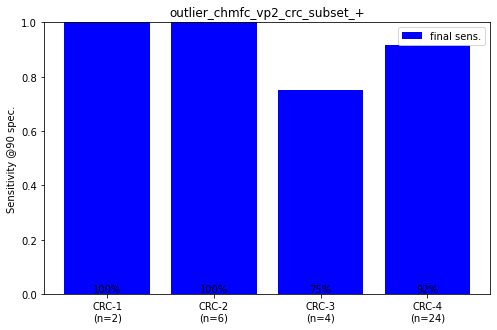

In [89]:
path = "Multi_cancer/Two_step_models/model_compare/more_crcs/outlier_chmfc_vp2_crc_subset_+" 

df_sample_avg = generate_exp_table(bucket, path, chains=2, spec=90)
crc_sens_by_stage(path, df_sample_avg)

   sample_id                                   fold  y_true   y_score  \
0       4991  metadata_balanced_kfold_cancer_type_0       0 -0.238698   
1       5006  metadata_balanced_kfold_cancer_type_0       0 -0.238698   
2      14879  metadata_balanced_kfold_cancer_type_0       0 -0.238698   
3      20042  metadata_balanced_kfold_cancer_type_0       0 -0.238698   
4      20050  metadata_balanced_kfold_cancer_type_0       0 -0.238698   

                        status stage_x subtype  inference  fold_call stage_y  \
0                Breast Cancer       2    None      False          1     IIB   
1                Breast Cancer       2    None      False          1     IIB   
2  Colorectal Normal / Healthy    None    None      False          1    None   
3            Pancreatic Cancer       2    None      False          1     IIA   
4            Pancreatic Cancer       2    None      False          1     IIB   

   chain0_score  chain1_score  maj_vote_call  score_mean  chain0_score_mean  \
0

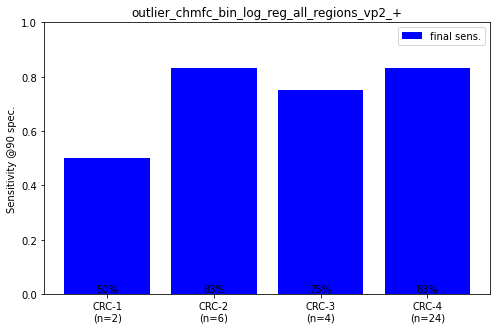

In [86]:

bucket = "freenome-user-data-bgould"
path = "Multi_cancer/Two_step_models/model_compare/more_crcs/outlier_chmfc_bin_log_reg_all_regions_vp2_+" 

df_sample_avg = generate_exp_table(bucket, path, chains=2, spec=90)
crc_sens_by_stage(path, df_sample_avg)

   sample_id                                   fold  y_true   y_score  \
0       4991  metadata_balanced_kfold_cancer_type_0       0 -0.455234   
1       5006  metadata_balanced_kfold_cancer_type_0       0 -0.455234   
2      14879  metadata_balanced_kfold_cancer_type_0       0 -0.455234   
3      20042  metadata_balanced_kfold_cancer_type_0       0 -0.455234   
4      20050  metadata_balanced_kfold_cancer_type_0       0 -0.455234   

                        status stage_x subtype  inference  fold_call stage_y  \
0                Breast Cancer       2    None      False          1     IIB   
1                Breast Cancer       2    None      False          1     IIB   
2  Colorectal Normal / Healthy    None    None      False          1    None   
3            Pancreatic Cancer       2    None      False          1     IIA   
4            Pancreatic Cancer       2    None      False          1     IIB   

   chain0_score  chain1_score  maj_vote_call  score_mean  chain0_score_mean  \
0

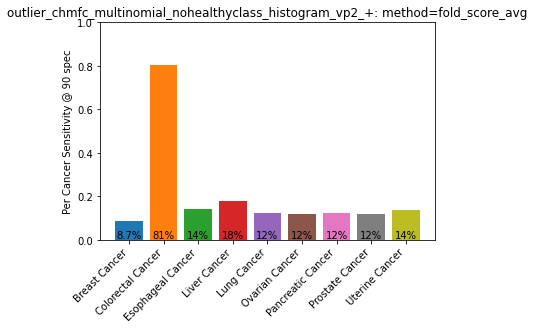

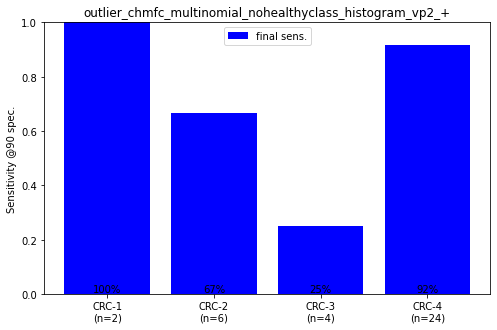

In [87]:

bucket = "freenome-user-data-bgould"
path = "Multi_cancer/Two_step_models/model_compare/more_crcs/outlier_chmfc_multinomial_nohealthyclass_histogram_vp2_+" 

df_sample_avg = generate_exp_table(bucket, path, chains=2, spec=90)
_ = plot_multicancer_sensitivities(df_sample_avg)
crc_sens_by_stage(path, df_sample_avg)
